# Field Validation LSTM 

In [1]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [2]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_gereinigt.csv')
#df = df.drop(columns=['Unnamed: 0']) 
df.head()


,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360


In [3]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape
#Reshape data for LSTM (add time step dimension)
test_data_scaled_normal = test_data_scaled_normal.values.reshape(test_data_scaled_normal.shape[0], 1, test_data_scaled_normal.shape[1])
test_data_scaled_abnormal = test_data_scaled_abnormal.values.reshape(test_data_scaled_abnormal.shape[0], 1, test_data_scaled_abnormal.shape[1])
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape


((2447, 1, 100), (239, 1, 100))

In [4]:
# Make predictions using lstm utoencoder
lstm = tf.keras.models.load_model('../../models/lstm_autoencoder_best.keras')
with open('../../models/lstm_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


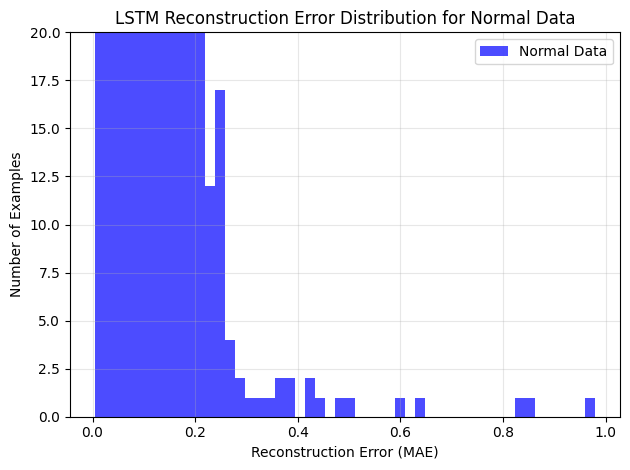

In [5]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = lstm.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.hist(train_loss_normal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Normal Data')

plt.title('LSTM Reconstruction Error Distribution for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0,20)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


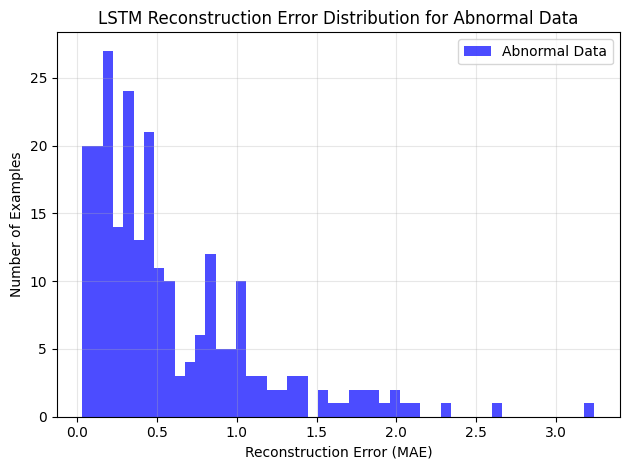

Mean reconstruction error: 0.0332
Median reconstruction error: 0.4270
Standard deviation: 0.5263


In [6]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = lstm.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.hist(train_loss_abnormal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Abnormal Data')

plt.title('LSTM Reconstruction Error Distribution for Abnormal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mean reconstruction error: {np.min(train_loss_abnormal):.4f}")
print(f"Median reconstruction error: {np.median(train_loss_abnormal):.4f}")
print(f"Standard deviation: {np.std(train_loss_abnormal):.4f}")

In [7]:
# # Find indices where LSTM reconstruction error of abnormal is less than 0.2
low_reconstruction_indices = np.where(train_loss_abnormal < 0.2)[0]

# Get the indices of abnormal samples in the original dataframe
abnormal_mask = df['curb_scene'] == 1
abnormal_indices = df[abnormal_mask].index

# Map the indices from abnormal subset to original dataframe indices
original_indices = abnormal_indices[low_reconstruction_indices]

print("\nCorresponding indices in original dataframe:")
print(original_indices)



Corresponding indices in original dataframe:
Index([ 240,  280,  520,  521,  687,  887,  888,  889,  891,  993, 1066, 1164,
       1172, 1270, 1271, 1272, 1273, 1348, 1350, 1356, 1415, 1416, 1492, 1493,
       1494, 1495, 1635, 1748, 1916, 1931, 2214, 2224, 2301, 2382, 2391, 2392,
       2397, 2399, 2410, 2417, 2419, 2420, 2422, 2427, 2429, 2461, 2464, 2466,
       2473, 2481, 2491, 2494, 2496, 2506],
      dtype='int64')


In [9]:
# # Find indices where reconstruction error of normal is greater than 0.3
big_reconstruction_indices = np.where(train_loss_normal > 0.3)[0]
# Get the indices of normal samples in the original dataframe
normal_mask = df['curb_scene'] == 0
normal_indices = df[normal_mask].index
# Map the indices from normal subset to original dataframe indices
original_indices = normal_indices[big_reconstruction_indices]
print("\nCorresponding indices in original dataframe:")
print(original_indices)


Corresponding indices in original dataframe:
Index([1241, 1242, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1397, 1398, 1399,
       1400, 1501, 2010, 2608],
      dtype='int64')


In [8]:
# Add the loss values back to the original DataFrame
df.loc[df['curb_scene'] == 0, 'loss'] = train_loss_normal.numpy()
df.loc[df['curb_scene'] == 1, 'loss'] = train_loss_abnormal.numpy()

In [ ]:
indices = [,]
df.iloc[indices, df.columns.get_loc('curb_scene')] = 0

In [237]:
df.iloc[2608, df.columns.get_loc('curb_scene')] = 1

In [241]:
# # Alternatively, for better notebook display:
df_selected = df[['curb_scene', 'start_time', 'loss']]
df_selected.iloc[2610:2610+30]

,curb_scene,start_time,loss
2610,0,2025-03-28 16:22:24.571,0.195023
2611,0,2025-03-28 16:22:25.068,0.204024
2612,0,2025-03-28 16:22:25.567,0.178985
2613,0,2025-03-28 16:22:26.063,0.192914
2614,0,2025-03-28 16:22:26.557,0.186736
2615,0,2025-03-28 16:22:27.054,0.094333
2616,0,2025-03-28 16:22:27.551,0.124345
2617,0,2025-03-28 16:22:28.048,0.097190
2618,0,2025-03-28 16:22:28.543,0.129305
2619,0,2025-03-28 16:22:29.040,0.087062


In [125]:
# Get indices where curb_scene is 1 and examine up/down values
abnormal_indices = df[df['curb_scene'] == 1].index

# Get two lists: isolated abnormal indices and consecutive abnormal indices
abnormal_odd = []

for idx in abnormal_indices:
    # Check if index is not at the boundaries of the dataframe
    if idx > 0 and idx < len(df) - 1:
        prev_value = df.loc[idx - 1, 'curb_scene']
        next_value = df.loc[idx + 1, 'curb_scene']
        
        if prev_value == 0 and next_value == 0:
            abnormal_odd.append(idx)
        if prev_value == 1 and next_value == 1:
            abnormal_odd.append(idx)

print(abnormal_odd)



[145, 194, 238, 247, 346, 347, 364, 432, 441, 461, 520, 521, 669, 681, 978, 1064, 1065, 1111, 1112, 1205, 1206, 1259, 1332, 1349, 1356, 1366, 1377, 1386, 1415, 1416, 1448, 1455, 1458, 1673, 1703, 1712, 1860, 1951, 2015, 2197, 2292, 2293, 2326, 2331, 2332, 2387, 2388, 2389, 2390, 2391, 2392, 2416, 2417, 2495, 2496, 2527, 2571, 2583, 2586, 2587, 2588, 2589, 2590, 2591, 2606]


In [242]:
df.to_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_changed.csv', index=False)